# Data Preprocessing
### Brendon Barrios     |     08/08/2020
Using OSIC Pulmonary Fibrosis Progression dataset from Kaggle.com

<https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression/overview>

In [1]:
import os
import matplotlib.pyplot as plt
import pydicom
import numpy as np
import cv2
import pandas as pd
import scipy.ndimage

#from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

DATA_DIR = "test_dl/"
patients = os.listdir(DATA_DIR)
patients.sort()

In [2]:
def load_scan(path):
    slices = [pydicom.read_file(os.path.join(path, file)) for file in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
    
    for s in slices:
        s.SliceThickness = slice_thickness
    
    return slices

In [3]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)
    
    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)    

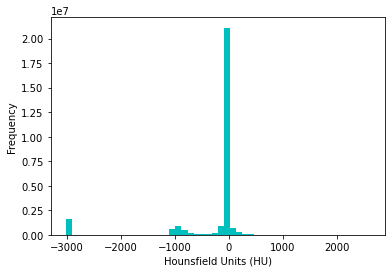

In [4]:
first_patient = load_scan(DATA_DIR + patients[0])
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=50, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

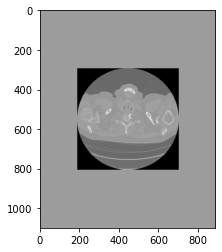

In [5]:
# Show some slice in the middle
plt.imshow(first_patient_pixels[-1], cmap=plt.cm.gray)
plt.show()